In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import control as ct

plt.style.use('../maroon_ipynb.mplstyle')

This is an extension to Example 2.5.1 in the book. This is how you get the response to a system that has multiple inputs. You add the forced response from each input function. For this example, the first input is $f(t)=t^2$, and the second input is $g(t)=e^{-5t}$.

In [2]:
t = sp.Symbol('t')
x = sp.Function('x')(t)
f = t**2
g = sp.exp(-5*t)

eq = sp.Eq(5*x.diff(t, 2) + 30*x.diff() + 40*x, 6*f - 20*g)
eq

Eq(40*x(t) + 30*Derivative(x(t), t) + 5*Derivative(x(t), (t, 2)), 6*t**2 - 20*exp(-5*t))

In [3]:
sol = sp.dsolve(eq, ics={
    x.subs(t, 0): 0,
    x.diff().subs(t, 0): 0
})
sol

Eq(x(t), 3*t**2/20 - 9*t/40 + 21/160 - 49*exp(-2*t)/60 + 323*exp(-4*t)/160 - 4*exp(-5*t)/3)

In [4]:
x_lamb = sp.lambdify(t, sol.rhs, modules='numpy')
t_array = np.linspace(0, 10, 500)

den = [5, 30, 40]  # all transfer functions have the same denominator (characteristic equation)
X_F = ct.tf(6, den)
X_G = ct.tf(-20, den)
display(X_F, X_G)

TransferFunction(array([6]), array([ 5, 30, 40]))

TransferFunction(array([-20]), array([ 5, 30, 40]))

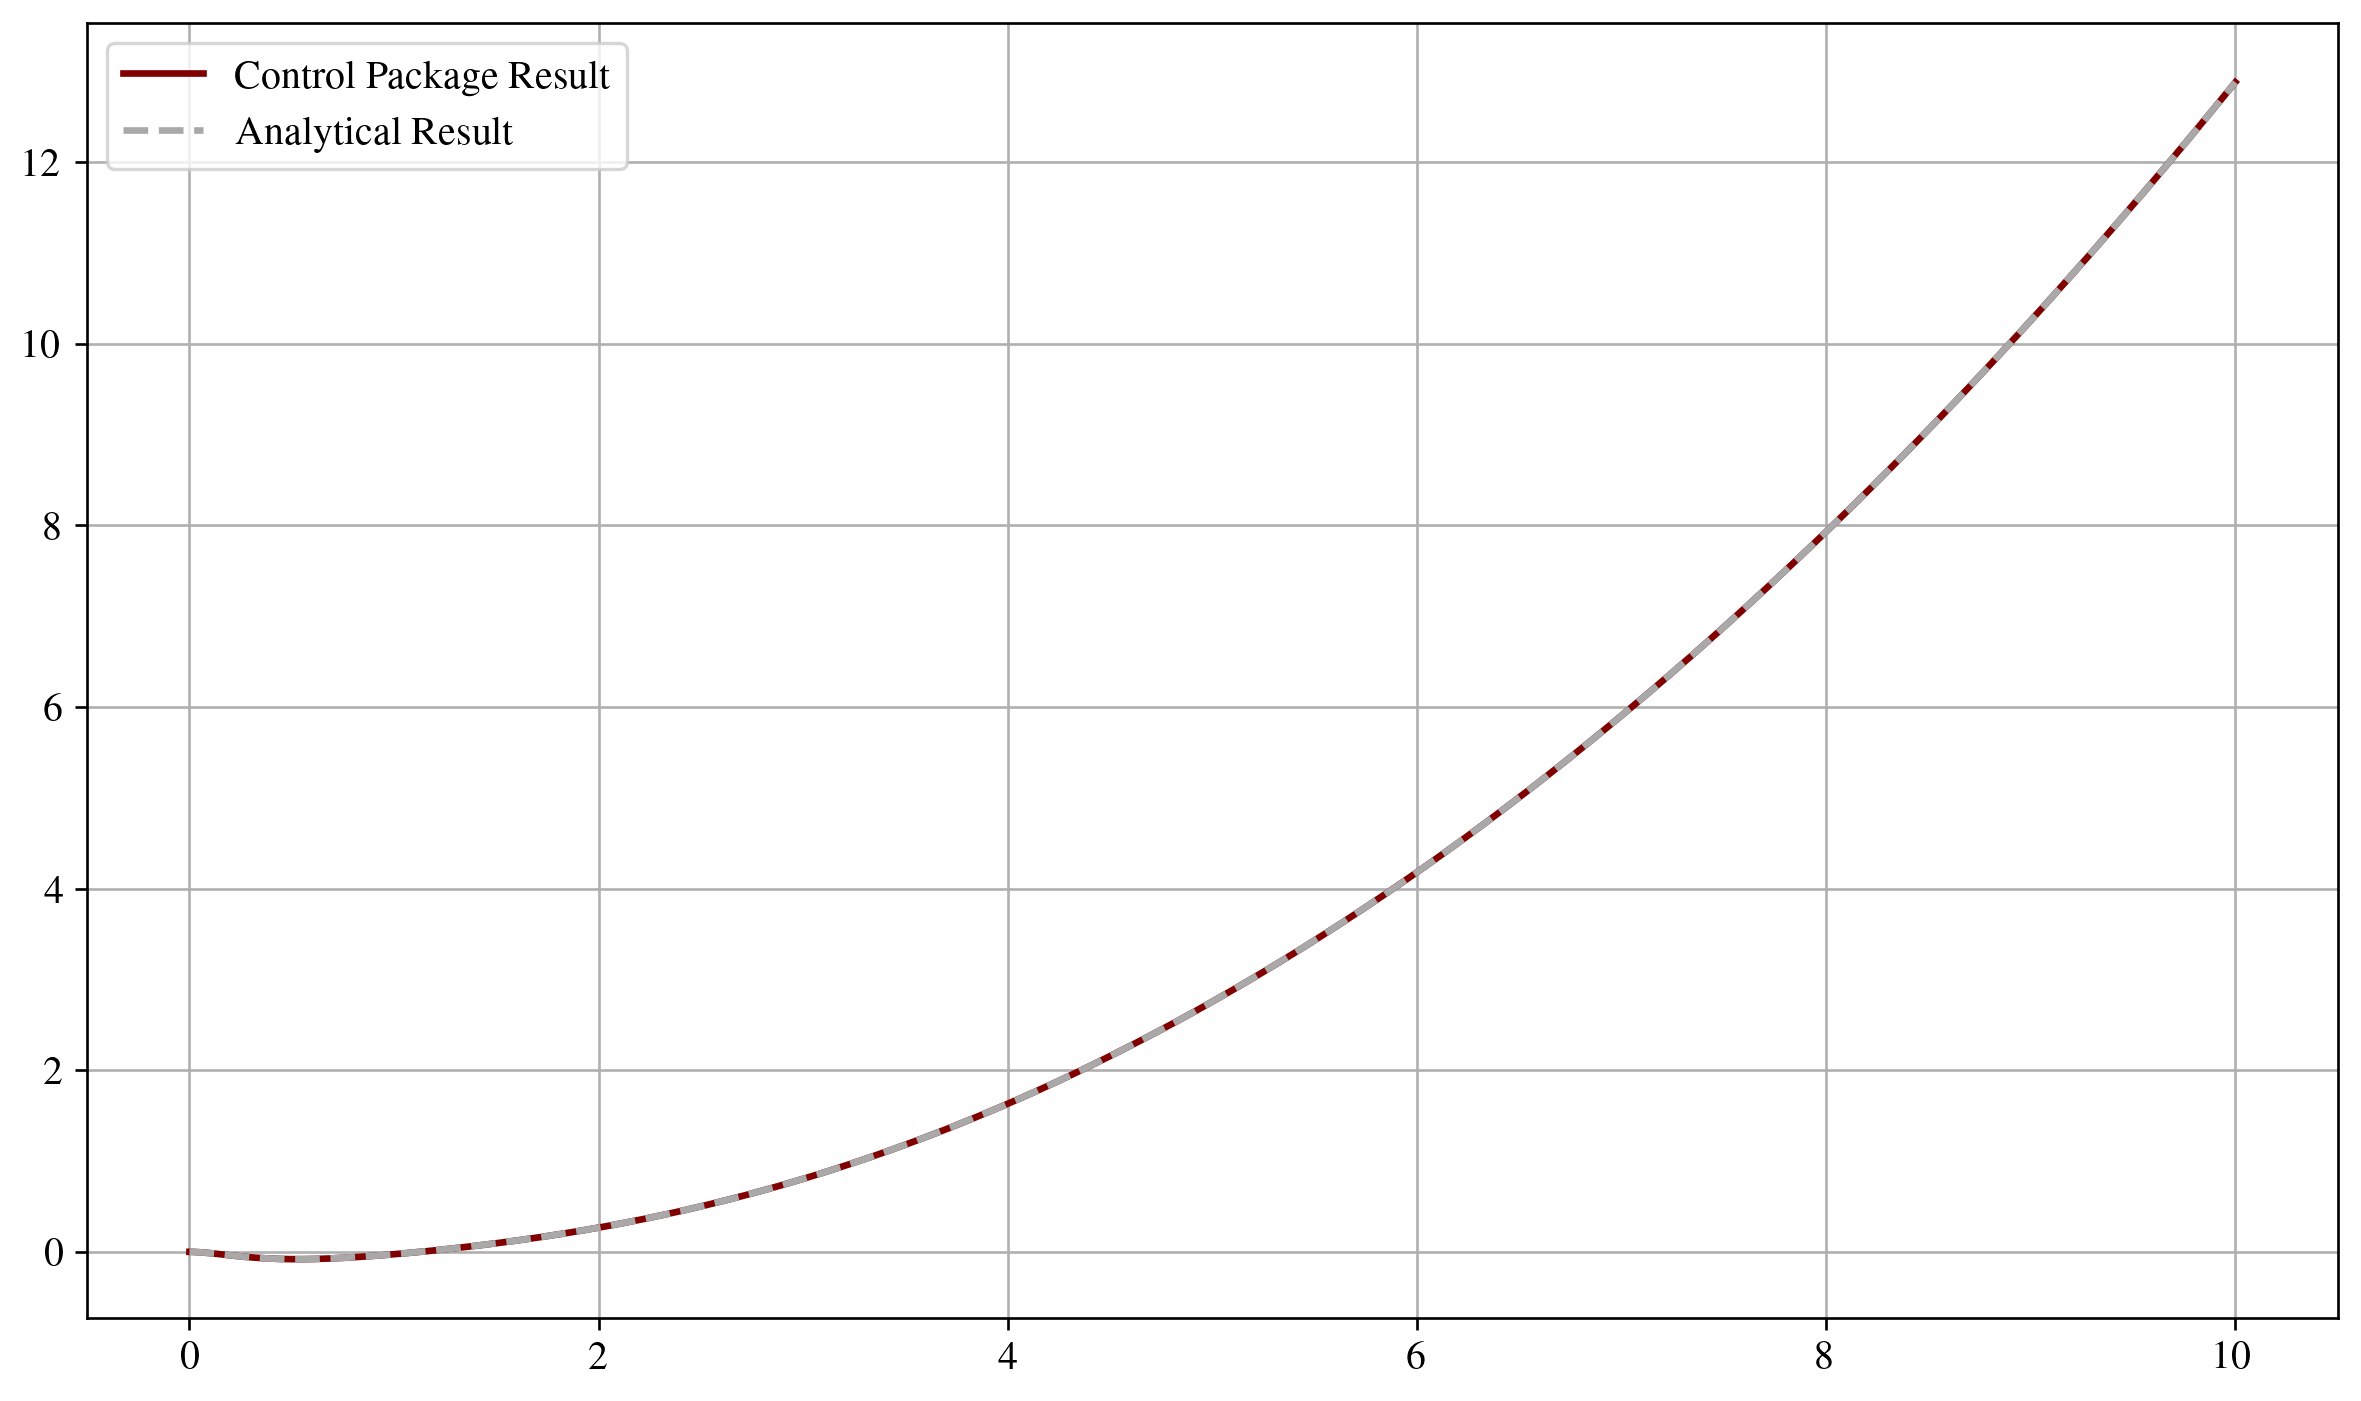

In [5]:
_, f_response = ct.forced_response(X_F, T=t_array, U=t_array**2)
_, g_response = ct.forced_response(X_G, T=t_array, U=np.exp(-5*t_array))
response = f_response + g_response

plt.plot(t_array, response, label='Control Package Result')
plt.plot(t_array, x_lamb(t_array), label='Analytical Result', ls='--', color='darkgrey')
plt.legend()
plt.show()

For a more complicated ODE or systems of ODE's, then it would be wise to use the state-variable form or state-space form. For example:

$$\dddot{x}_0+5\ddot{x}_0+7\dot{x}_0+3x_0=f(t)+g(t)$$

In [6]:
x0 = sp.Function('x0')(t)
eq1 = sp.Eq(x0.diff(t, 3) + 5*x0.diff(t, 2) + 7*x0.diff() + 3*x0, f + g)
eq1

Eq(3*x0(t) + 7*Derivative(x0(t), t) + 5*Derivative(x0(t), (t, 2)) + Derivative(x0(t), (t, 3)), t**2 + exp(-5*t))

In [7]:
d_sol = sp.dsolve(eq1, ics={x0.diff(t, 2).subs(t, 0): 0, x0.diff().subs(t, 0): 0, x0.subs(t, 0): 0})
x0_lamb = sp.lambdify(t, d_sol.rhs, modules='numpy')
d_sol

Eq(x0(t), t**2/3 - 14*t/9 + (-7*t/8 - 83/32)*exp(-t) + 68/27 + 23*exp(-3*t)/216 - exp(-5*t)/32)

In [8]:
# Putting in state variable form
x1, x2 = sp.Function('x1')(t), sp.Function('x2')(t)

eq2 = sp.Eq(x0.diff(), x1)
eq3 = sp.Eq(x1.diff(), x2)

sub_states = [
    (x0.diff(t, 3), x2.diff()),
    (x0.diff(t, 2), x1.diff()),
    (x1.diff(), x2)
]

eq1 = eq1.subs(sub_states)
state_sol = sp.solve([eq1, eq2, eq3], [x0.diff(), x1.diff(), x2.diff()], dict=True)[0]
for key, value in state_sol.items(): display(sp.Eq(key, value))

Eq(Derivative(x0(t), t), x1(t))

Eq(Derivative(x1(t), t), x2(t))

Eq(Derivative(x2(t), t), t**2 - 3*x0(t) - 7*x1(t) - 5*x2(t) + exp(-5*t))

In [9]:
A = [
    [0, 1, 0],
    [0, 0, 1],
    [-3, -7, -5]
]

B = [
    [0, 0],
    [0, 0],
    [1, 1]
]

C = [
    [1, 0, 0]
]

D = [[0, 0]]

ss1 = ct.ss(A, B, C, D)
ss1

<LinearIOSystem:sys[6]:['u[0]', 'u[1]']->['y[0]']>

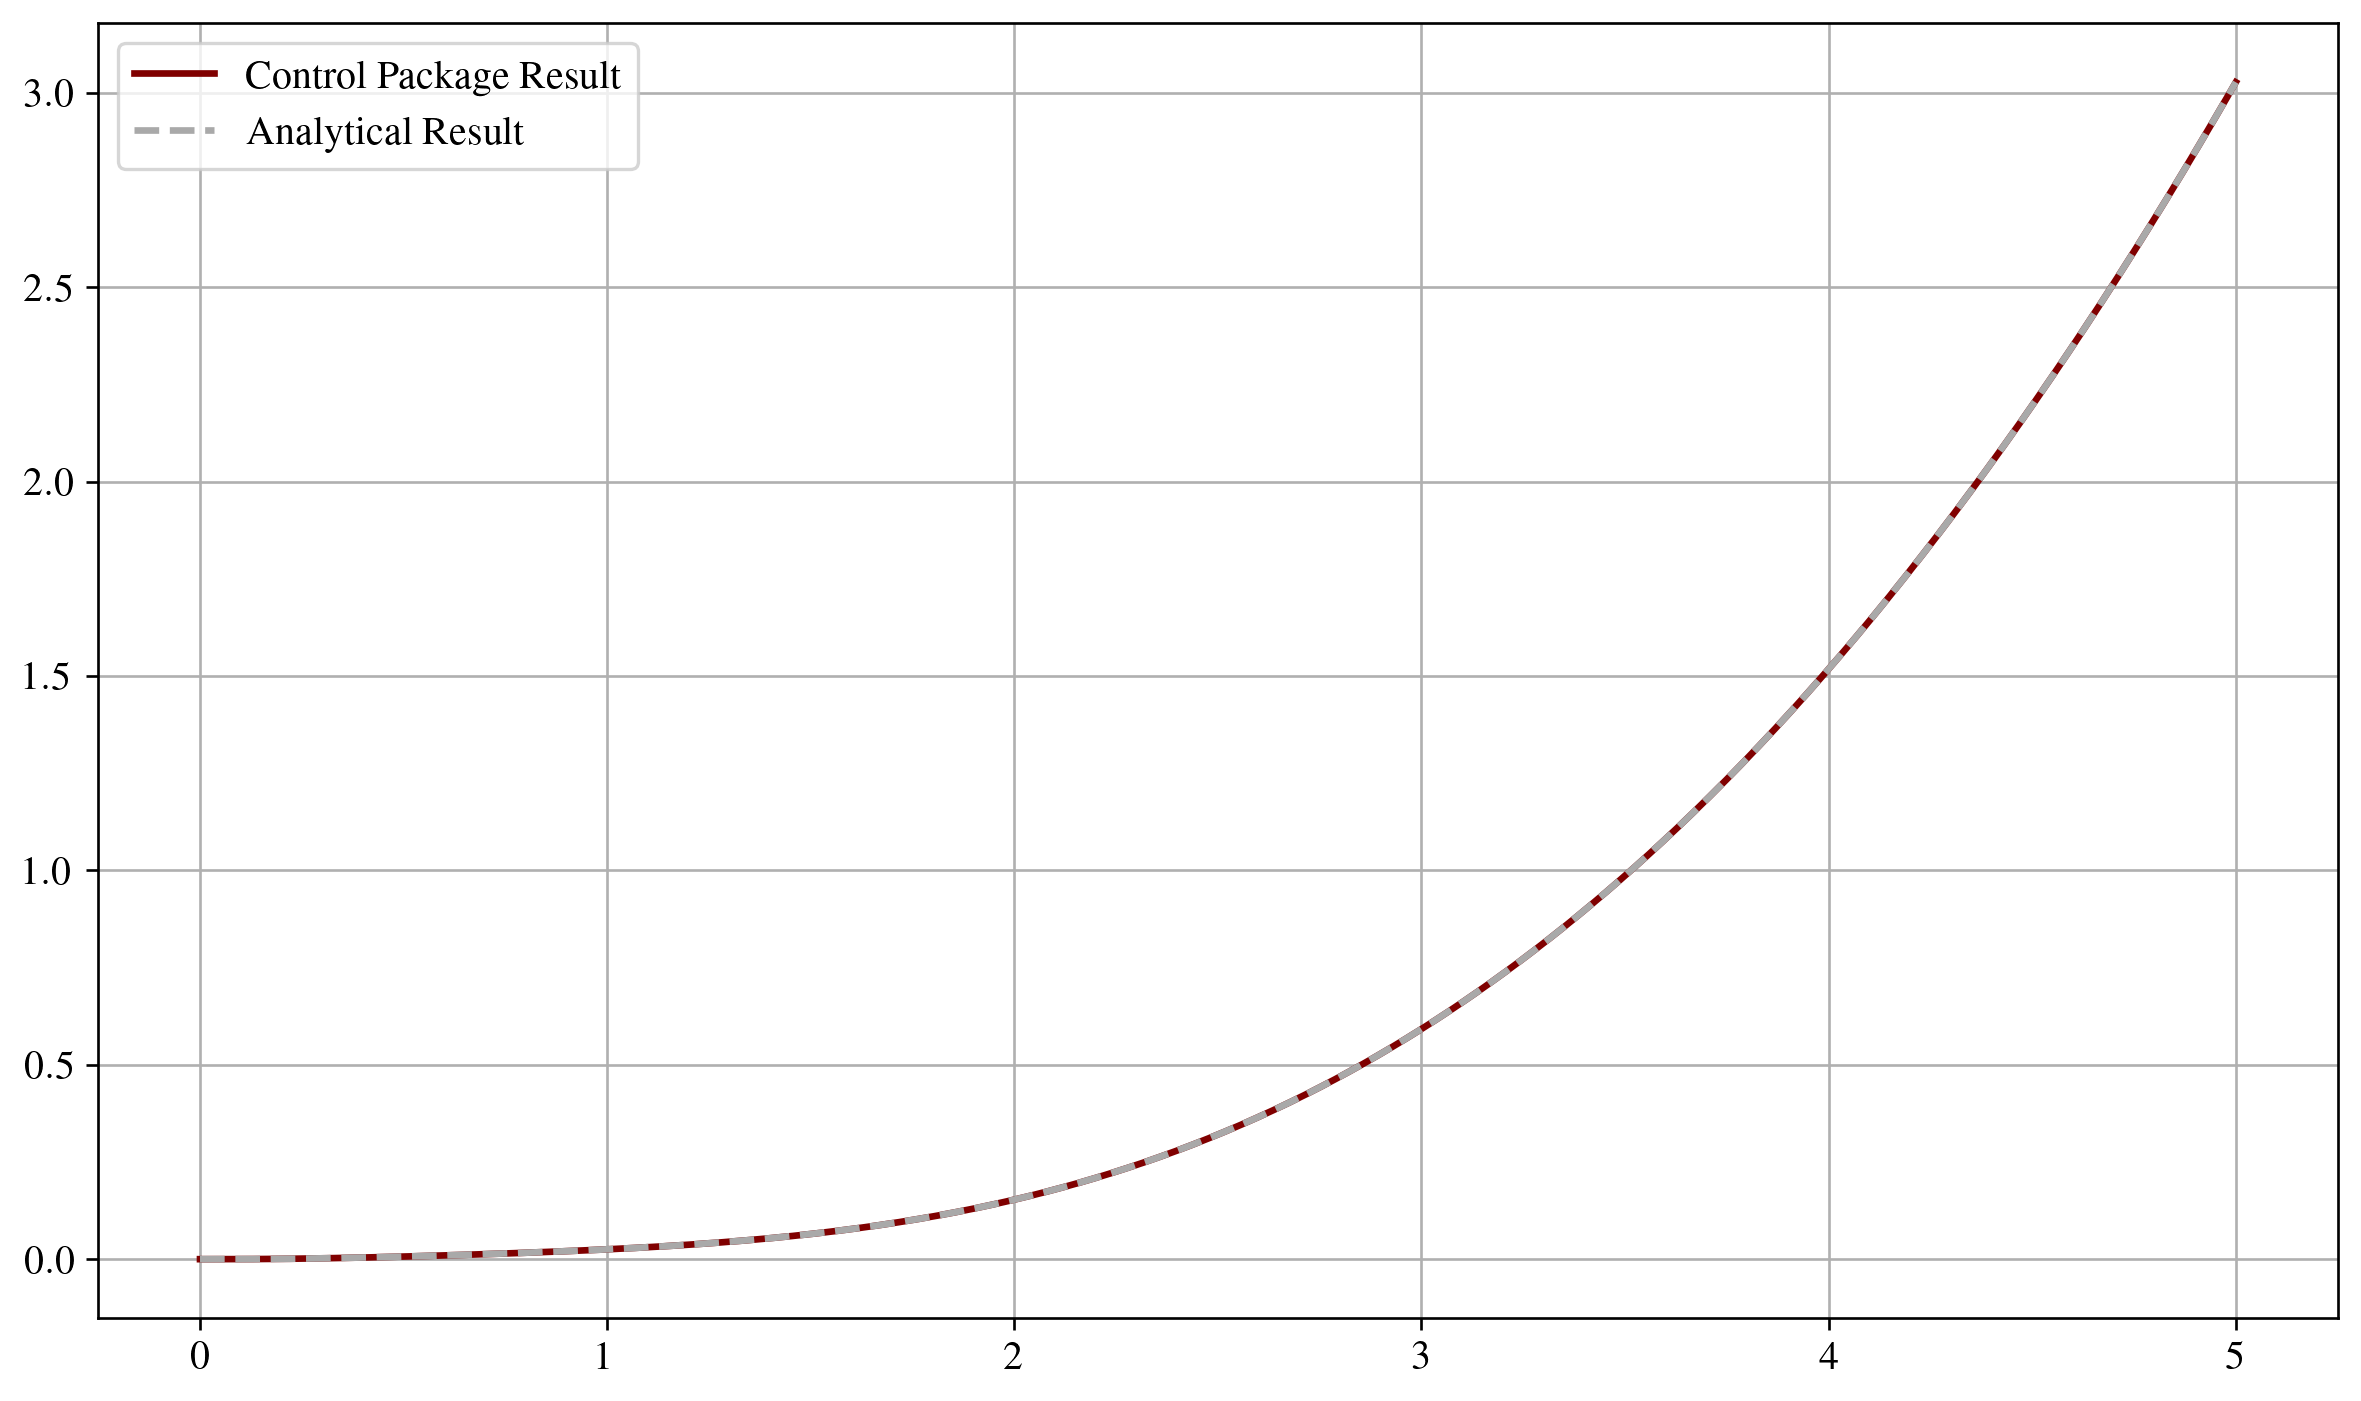

In [10]:
f_lamb = lambda t_: t_**2
g_lamb = lambda t_: np.exp(-5*t_)

t_array = np.linspace(0, 5, 1000)
inp = np.stack([f_lamb(t_array), g_lamb(t_array)])  # Input has to be stacked and be 2x1000

_, sol_con = ct.forced_response(ss1, T=t_array, U=inp)

plt.plot(t_array, sol_con[0], label='Control Package Result')
plt.plot(t_array, x0_lamb(t_array), ls='--', label='Analytical Result', color='darkgrey')
plt.legend()
plt.show()